# ACCESS-OM2 Along Slope Anomaly

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
from pathlib import Path
import xgcm

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44819/status,
Dashboard: /proxy/44819/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33789,Workers: 28
Dashboard: /proxy/44819/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:42431,Total threads: 1
Dashboard: /proxy/38079/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:35241,


In [3]:
#Importing data
pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean.nc'))

In [23]:
# Time variant variables
def preprocess(ds):
    ds = ds[['u', 'v','salt','dzt']].sel(yt_ocean = slice(-80, -59),yu_ocean = slice(-80, -59), st_ocean = slice(None, 500))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [5]:
# Time mean (last 5 yrs)
uC = cont['u'].sel(time=slice('1915-01-01','1919-12-31')).mean('time')
vC = cont['v'].sel(time=slice('1915-01-01','1919-12-31')).mean('time')
uM = melt['u'].sel(time=slice('1915-01-01','1919-12-31')).mean('time')
vM = melt['v'].sel(time=slice('1915-01-01','1919-12-31')).mean('time')

All of the above variables are on the xu_ocean/yu_ocean grid. 

In [6]:
lat_slice = slice(-80, -59)

In [7]:
path_to_ocean_static_C = Path('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')
ocean_static_C = xr.open_dataset(path_to_ocean_static_C).sel(yu_ocean=lat_slice,yt_ocean=lat_slice)

path_to_ocean_static_M = Path('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/output039/ocean/ocean_grid.nc')
ocean_static_M = xr.open_dataset(path_to_ocean_static_M).sel(yu_ocean=lat_slice,yt_ocean=lat_slice)

In [8]:
cont_n = xr.merge([uC,vC,ocean_static_C])
cont_n= cont_n.isel(xu_ocean = slice(1, None), yu_ocean = slice(1, None))

pert_n = xr.merge([uM,vM,ocean_static_M])
pert_n= pert_n.isel(xu_ocean = slice(1, None), yu_ocean = slice(1, None))

In [9]:
# For control
ocean_static_C = ocean_static_C.sel(xu_ocean = cont_n['xu_ocean'], xt_ocean = cont_n['xt_ocean'], 
                                    yu_ocean = cont_n['yu_ocean'], yt_ocean = cont_n['yt_ocean'])

grid_C = ocean_static_C[['xt_ocean','xu_ocean','yt_ocean','yu_ocean']]
ds_hu_C = ocean_static_C[['hu','dxu','dyt']]

# For meltwater
ocean_static_M = ocean_static_M.sel(xu_ocean = cont_n['xu_ocean'], xt_ocean = cont_n['xt_ocean'], 
                                    yu_ocean = cont_n['yu_ocean'], yt_ocean = cont_n['yt_ocean'])

grid_M = ocean_static_M[['xt_ocean','xu_ocean','yt_ocean','yu_ocean']]
ds_hu_M = ocean_static_M[['hu','dxu','dyt']]

In [10]:
ds_C = xr.merge([ds_hu_C, grid_C])
ds_C.coords['xt_ocean'].attrs.update(axis='X')
ds_C.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds_C.coords['yt_ocean'].attrs.update(axis='Y')
ds_C.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

ds_M = xr.merge([ds_hu_M, grid_M])
ds_M.coords['xt_ocean'].attrs.update(axis='X')
ds_M.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds_M.coords['yt_ocean'].attrs.update(axis='Y')
ds_M.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

In [11]:
grid_C = xgcm.Grid(ds_C, periodic=['X'])
grid_M = xgcm.Grid(ds_M, periodic=['X'])

In [12]:
# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx_C = grid_C.interp( grid_C.diff(ds_C.hu, 'X') / grid_C.interp(ds_C.dxu, 'X'), 'X')
dhu_dx_M = grid_M.interp( grid_M.diff(ds_M.hu, 'X') / grid_M.interp(ds_M.dxu, 'X'), 'X')

# In meridional direction, we need to specify what happens at the boundary
dhu_dy_C = grid_C.interp( grid_C.diff(ds_C.hu, 'Y', boundary='extend') / grid_C.interp(ds_C.dyt, 'X'), 'Y', boundary='extend')
dhu_dy_M = grid_M.interp( grid_M.diff(ds_M.hu, 'Y', boundary='extend') / grid_M.interp(ds_M.dyt, 'X'), 'Y', boundary='extend')

# Select latitude slice
dhu_dx_C = dhu_dx_C.sel(yu_ocean=lat_slice)
dhu_dy_C = dhu_dy_C.sel(yu_ocean=lat_slice)

dhu_dx_M = dhu_dx_M.sel(yu_ocean=lat_slice)
dhu_dy_M = dhu_dy_M.sel(yu_ocean=lat_slice)

In [13]:
# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude_C = np.sqrt(dhu_dx_C**2 + dhu_dy_C**2)
topographic_slope_magnitude_M = np.sqrt(dhu_dx_M**2 + dhu_dy_M**2)

In [14]:
# Along-slope velocity
alongslope_velocity_C = uC * dhu_dy_C / topographic_slope_magnitude_C - vC * dhu_dx_C / topographic_slope_magnitude_C
alongslope_velocity_C

<xarray.DataArray (st_ocean: 39, yu_ocean: 483, xu_ocean: 3599)> Size: 271MB
dask.array<sub, shape=(39, 483, 3599), dtype=float32, chunksize=(38, 161, 287), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * xu_ocean  (xu_ocean) float64 29kB -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.95 -79.9 -79.86 ... -59.06 -59.01

In [15]:
# Along-slope velocity
alongslope_velocity_M = uM * dhu_dy_M / topographic_slope_magnitude_M - vM * dhu_dx_M / topographic_slope_magnitude_M
alongslope_velocity_M

<xarray.DataArray (st_ocean: 39, yu_ocean: 483, xu_ocean: 3599)> Size: 271MB
dask.array<sub, shape=(39, 483, 3599), dtype=float32, chunksize=(38, 242, 360), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * xu_ocean  (xu_ocean) float64 29kB -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -79.95 -79.9 -79.86 ... -59.06 -59.01

In [16]:
alongslope_velocity_C = alongslope_velocity_C.astype('float32')
alongslope_velocity_M = alongslope_velocity_M.astype('float32')

In [17]:
alongslope_velocity_C = alongslope_velocity_C.load()

In [18]:
alongslope_velocity_M = alongslope_velocity_M.load()

In [20]:
alongslope_velocity_C = grid_C.interp(grid_C.interp(alongslope_velocity_C, 'Y'), 'X')
alongslope_velocity_M = grid_M.interp(grid_M.interp(alongslope_velocity_M, 'Y'), 'X')
alongslope_velocity_C

<xarray.DataArray (st_ocean: 39, yt_ocean: 483, xt_ocean: 3600)> Size: 271MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.07011739, -0.06603006, -0.05076946, ..., -0.0509974 ,
         -0.07022233, -0.07011739],
        [-0.07264607, -0.07025029, -0.06038108, ..., -0.05268154,
         -0.07091723, -0.07264607],
        [-0.07123239, -0.0723647 , -0.069389  , ..., -0.04046655,
         -0.06371702, -0.07123239]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.00904524, -0.00860804, -0.00668714, ..., -0.00423091,
         -0.00873506, -0.00904524],
        [-0.0105994 , -0.0107758 , -0.00791073, ..., -0.0053282 ,
         -0.00935187, -0.0105994 ],
        [-0.0103279 , -0.01125519, -0.01016781, ..., -0.00356342,
         -0.00796983, -0.0103279 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.00865581, -0.00819358, -0.00634867, ..., -0.00420412,
         -0.00840108, -0.00865581],
        [-0.01022983, -0.01035766, -0.00758475, ..., -0.00528205,
         -0.00905602, -0.01022983],
        [-0.00994924, -0.01085369, -0.00976513, ..., -0.0035271 ,
         -0.00766641, -0.00994924]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
Dimensions without coordinates: st_ocean

In [21]:
depth = xr.open_dataset(path_to_ocean_static_C)['ht']
area = xr.open_dataset(path_to_ocean_static_C)['area_t']
var = cont['salt'].isel(time=0,st_ocean=0)

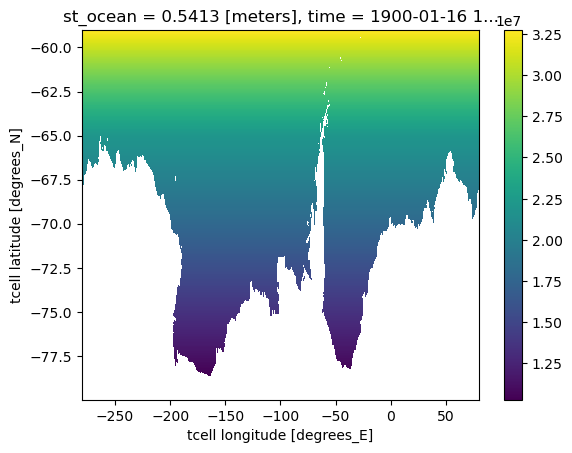

In [22]:
area_corr = area*(var*0 +1)
area_corr.plot()

In [24]:
thickness_C = cont['dzt'].sel(time=slice('1915-01-01','1919-12-31')).mean('time')
thickness_C

<xarray.DataArray 'dzt' (st_ocean: 39, yt_ocean: 483, xt_ocean: 3600)> Size: 271MB
dask.array<mean_agg-aggregate, shape=(39, 483, 3600), dtype=float32, chunksize=(38, 243, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4

In [25]:
thickness_M = melt['dzt'].sel(time=slice('1915-01-01','1919-12-31')).mean('time')
thickness_M

<xarray.DataArray 'dzt' (st_ocean: 39, yt_ocean: 483, xt_ocean: 3600)> Size: 271MB
dask.array<mean_agg-aggregate, shape=(39, 483, 3600), dtype=float32, chunksize=(38, 243, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4

In [27]:
# Depth average gives us the barotropic velocity
barotropic_alongslope_velocity_C = (alongslope_velocity_C * thickness_C).sum('st_ocean') / thickness_C.sum('st_ocean')
barotropic_alongslope_velocity_M = (alongslope_velocity_M * thickness_M).sum('st_ocean') / thickness_M.sum('st_ocean')

In [28]:
barotropic_alongslope_velocity_C

<xarray.DataArray (yt_ocean: 483, xt_ocean: 3600)> Size: 7MB
dask.array<truediv, shape=(483, 3600), dtype=float32, chunksize=(243, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03

In [29]:
barotropic_alongslope_velocity_C = barotropic_alongslope_velocity_C.load()

In [30]:
barotropic_alongslope_velocity_M = barotropic_alongslope_velocity_M.load()

In [31]:
barotropic_alongslope_velocity_anom = barotropic_alongslope_velocity_M - barotropic_alongslope_velocity_C

In [32]:
barotropic_alongslope_velocity_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_cont_prescribed_ACCESS.nc')
barotropic_alongslope_velocity_M.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_melt_prescribed_ACCESS.nc')
barotropic_alongslope_velocity_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_anom_prescribed_ACCESS.nc')

# Plotting

In [33]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.275
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [34]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

In [35]:
def shelf_mask_isobath(var, model_dict):

    paths = {"mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc", 
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [36]:
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)

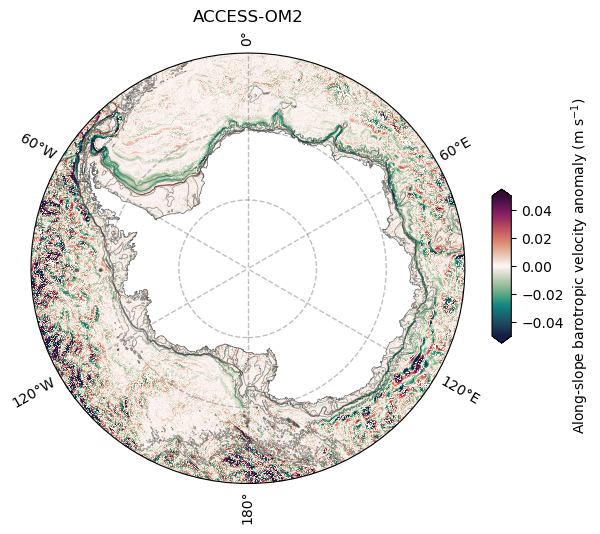

In [38]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.1,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Depth contours
depth.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 0.75, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = barotropic_alongslope_velocity_anom.plot(ax=ax, cmap=cm.cm.curl,
                                         transform=ccrs.PlateCarree(),
                                         vmin=-0.05, vmax=0.05,
                                         cbar_kwargs={'orientation': 'vertical',
                                                      'shrink': 0.25,
                                                      'extend': 'both',
                                                      'label': 'Along-slope barotropic velocity anomaly (m s$^{-1}$)',
                                                      'aspect': 8})
  
ax.set_title('ACCESS-OM2');